In [1]:
import os
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(1234)

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
path_data = r'/content/drive/MyDrive/Colab Notebooks/'

# Contains txt files
label_dir = path_data + 'garbage_txt/'
# Contains img files
image_dir = path_data + 'garbage_img/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read labels

In [3]:
# Read train, validation, test split from txt files
train_file = label_dir + 'one-indexed-files-notrash_train.txt'
val_file   = label_dir + 'one-indexed-files-notrash_val.txt'
test_file  = label_dir + 'one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])
df_test  = pd.read_csv(test_file,   sep=' ', header=None, names=['path', 'label'])

# Converts label id to name
def label_id_to_name(id):
  label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
  return label_map[id]

df_train['label'] = df_train['label'].apply(label_id_to_name)
df_valid['label'] = df_valid['label'].apply(label_id_to_name)
df_test['label'] = df_test['label'].apply(label_id_to_name)

# Change file name to file path i.e. cardboard114.jpg	 to cardboard/cardboard114.jpg	
df_train.path = df_train.path.str.extract(r'([a-z]+)')[0] + "/" + df_train.path
df_valid.path = df_valid.path.str.extract(r'([a-z]+)')[0] + "/" + df_valid.path
df_test.path = df_test.path.str.extract(r'([a-z]+)')[0] + "/" + df_test.path

In [4]:
display(df_train.head())
display(df_valid.head())
display(df_test.head())

,path,label
0,cardboard/cardboard202.jpg,cardboard
1,paper/paper472.jpg,paper
2,paper/paper522.jpg,paper
3,glass/glass189.jpg,glass
4,glass/glass325.jpg,glass


,path,label
0,cardboard/cardboard114.jpg,cardboard
1,plastic/plastic204.jpg,plastic
2,glass/glass123.jpg,glass
3,glass/glass152.jpg,glass
4,glass/glass398.jpg,glass


,path,label
0,paper/paper70.jpg,paper
1,paper/paper380.jpg,paper
2,cardboard/cardboard31.jpg,cardboard
3,glass/glass12.jpg,glass
4,paper/paper169.jpg,paper


In [5]:
print("Size of training data", len(df_train))
print("Size of validation data", len(df_valid))
print("Size of test data", len(df_test))

Size of training data 1768
Size of validation data 328
Size of test data 431


# Read images

In [6]:
# Set data directory and parameters
batch_size = 32
image_size = (224, 224)

# Create data generator with data augmentation and shuffling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

datagen = ImageDataGenerator(
    rescale=1./255
)

# Load train, validation, and test data from all dataframes
train_data = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = image_dir,
    x_col = 'path',
    y_col= 'label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1234
)

val_data = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = image_dir,
    x_col = 'path',
    y_col= 'label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1234
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


# Construct model

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

opt = Adam(learning_rate=0.001)

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=20,
    validation_data=val_data,
    validation_steps=val_data.samples // batch_size,
    callbacks=[early_stop],
)

Epoch 1/20
55/55 [==============================] - 40s 689ms/step - loss: 1.7210 - accuracy: 0.2126 - val_loss: 1.6274 - val_accuracy: 0.3344
Epoch 2/20
55/55 [==============================] - 38s 678ms/step - loss: 1.6095 - accuracy: 0.3076 - val_loss: 1.6187 - val_accuracy: 0.2875
Epoch 3/20
55/55 [==============================] - 37s 675ms/step - loss: 1.4803 - accuracy: 0.3975 - val_loss: 1.5124 - val_accuracy: 0.3281
Epoch 4/20
55/55 [==============================] - 38s 675ms/step - loss: 1.3925 - accuracy: 0.4130 - val_loss: 1.3926 - val_accuracy: 0.4469
Epoch 5/20
55/55 [==============================] - 37s 672ms/step - loss: 1.3323 - accuracy: 0.4608 - val_loss: 1.4578 - val_accuracy: 0.4156
Epoch 6/20
55/55 [==============================] - 37s 674ms/step - loss: 1.3389 - accuracy: 0.4683 - val_loss: 1.2991 - val_accuracy: 0.4688
Epoch 7/20
55/55 [==============================] - 38s 676ms/step - loss: 1.2793 - accuracy: 0.4781 - val_loss: 1.2399 - val_accuracy: 0.4656

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 128)     

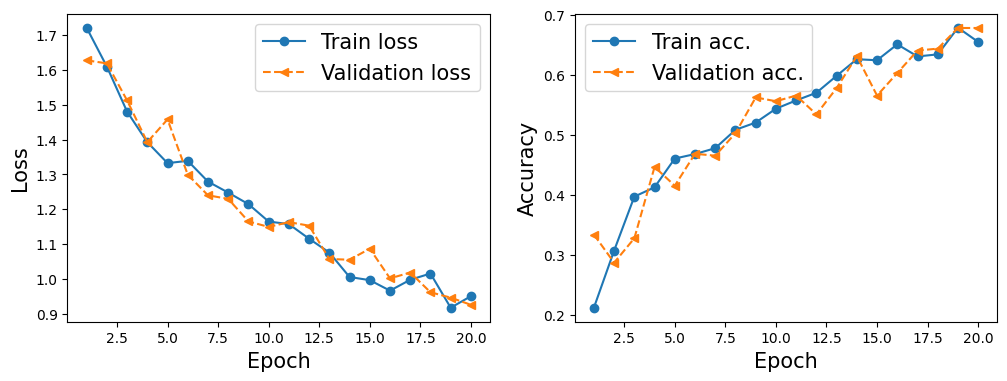

In [18]:
# Plot loss and accuracy data
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

# Evaluate model performance

In [20]:
# Evaluate model performance on test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=image_dir,
    x_col="path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=1234
)

test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Found 431 validated image filenames belonging to 6 classes.
14/14 [==============================] - 3s 186ms/step - loss: 0.8977 - accuracy: 0.6798
Test loss: 0.8977435827255249
Test accuracy: 0.6798143982887268


14/14 [==============================] - 3s 166ms/step


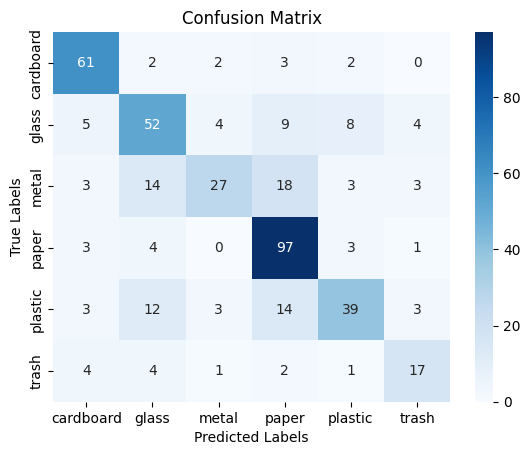

In [21]:
# Print confusion matrix

y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

cm = confusion_matrix(y_true_labels, y_pred_labels)
# Create heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

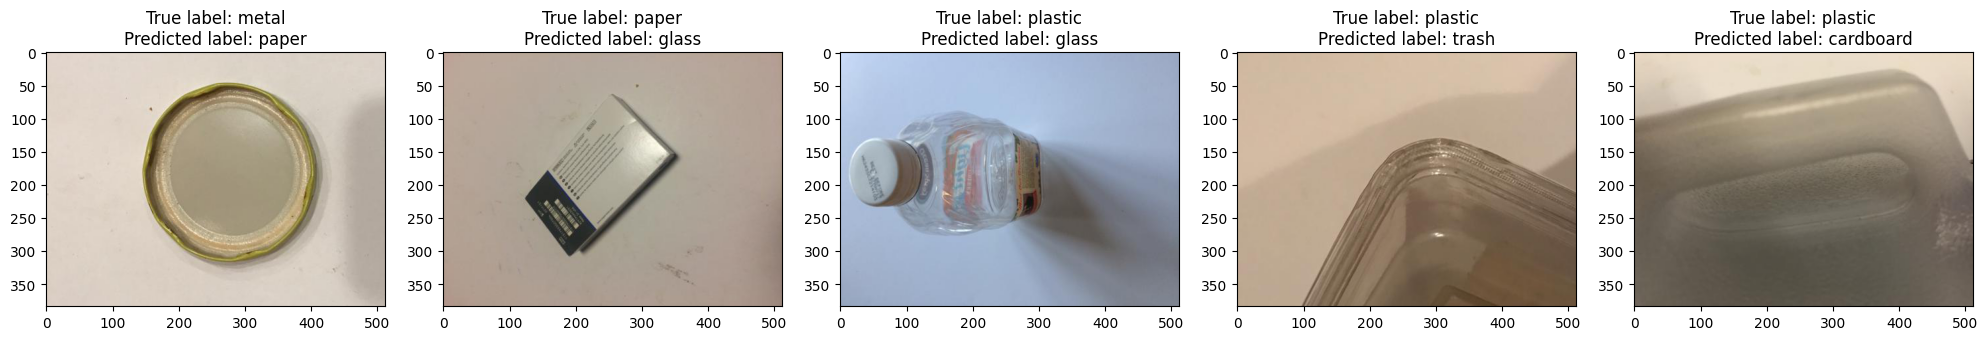

In [22]:
# Print few wrongly classified images

wrong_indices = np.where(y_true_labels != y_pred_labels)[0]
num_samples = 5
samples = np.random.choice(wrong_indices, size=num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))

for i, sample in enumerate(samples):
    img_path = test_data.filepaths[sample]
    img = plt.imread(img_path)
    true_label = class_names[y_true_labels[sample]]
    predicted_label = class_names[y_pred_labels[sample]]
    axes[i].imshow(img)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    
plt.tight_layout()
plt.show()

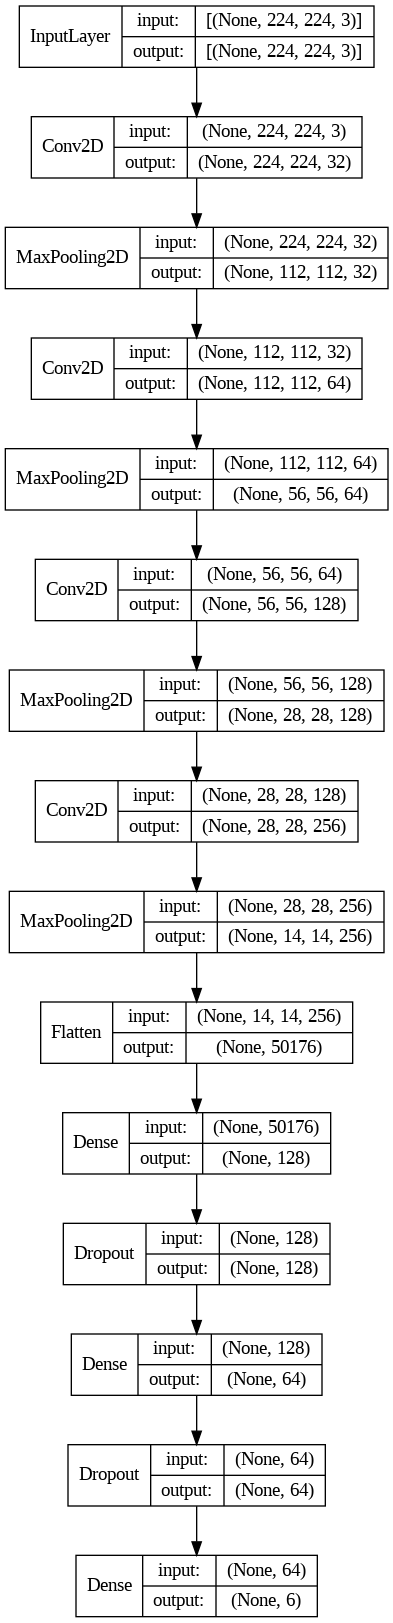

In [25]:
from tensorflow.keras.utils import plot_model

# Plot the model with the new layer names
plot_model(model, to_file='cnn_model.png',show_layer_names=False, show_shapes=True)

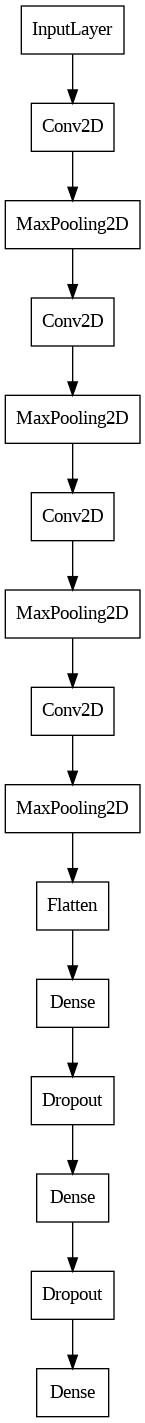

In [27]:
from tensorflow.keras.utils import plot_model

# Plot the model with the new layer names
plot_model(model, to_file='cnn_model.png',show_layer_names=False)